<a href="https://colab.research.google.com/github/pavithra64/fashion_stores_sales_clustering/blob/main/Fashion_stores_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer segmentation**

In [1]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fashion_Store_Sales_Data.xlsx to Fashion_Store_Sales_Data.xlsx


In [93]:
df=pd.read_excel('Fashion_Store_Sales_Data.xlsx')

In [95]:
df.head()

,Customer ID,Full Name,Date of Birth,Gender,Nationality,Email Address,Phone Number,Mailing Address,Preferred Contact Method,Occupation,Income Level,Education Level,Marital Status
0,PIKJ544M,Mario Wright,1996-02-07,Female,Gambia,weberjennifer@anderson.net,399-975-4857x534,"20329 Terri Road Suite 241, Simpsontown, NE 36621",Email,Dealer,High,Master's,Married
1,50P3LODM,Darryl Jackson,1987-09-05,Female,Guinea,mlee@potter.com,001-621-778-8461,"10891 Samuel Grove, Lauraport, TN 41573",Email,Economist,Low,PhD,Divorced
2,KHQXNMNV,Victor Gonzalez,1989-12-03,Female,Botswana,amy82@hotmail.com,+1-935-325-5368,"095 Oscar Isle, Garciaport, SD 99859",SMS,Management consultant,Middle,High School,Divorced
3,YDXJGO6Z,Joseph Solis,1987-08-03,Male,Tunisia,kdudley@steele-johnson.com,686.353.1684x3860,"USNS Barrera, FPO AE 33291",Email,"Engineer, agricultural",Middle,PhD,Married
4,W8UAEVIU,Jordan Horton,2002-11-03,Female,Chile,sara65@gmail.com,(458)971-9124x480,"564 Jacob Spurs, Lake Alexanderbury, MI 16554",SMS,Newspaper journalist,Middle,PhD,Single


In [96]:
df.shape

(1000, 13)

In [97]:
df.describe()

,Date of Birth
count,1000
mean,1979-04-03 20:36:57.600000
min,1953-10-22 00:00:00
25%,1966-02-07 06:00:00
50%,1979-02-03 12:00:00
75%,1992-03-05 00:00:00
max,2006-09-18 00:00:00


In [98]:
df.columns

Index(['Customer ID', 'Full Name', 'Date of Birth', 'Gender', 'Nationality',
       'Email Address', 'Phone Number', 'Mailing Address',
       'Preferred Contact Method', 'Occupation', 'Income Level',
       'Education Level', 'Marital Status'],
      dtype='object')

**Preprocessing**

In [99]:
df.isnull().sum()

,0
Customer ID,0
Full Name,0
Date of Birth,0
Gender,0
Nationality,0
Email Address,0
Phone Number,0
Mailing Address,0
Preferred Contact Method,0
Occupation,0


In [100]:
df.duplicated().sum()

0

In [101]:
#Feature selection
features = ['Gender', 'Nationality', 'Preferred Contact Method', 'Occupation', 'Income Level', 'Education Level', 'Marital Status']
data = df[features]

In [102]:
#One-Hot Encoding for Categorical features
categorical_features = features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features), index=data.index)

In [103]:
#Combining encoded features with Original data
data = pd.concat([data, encoded_df], axis=1)
data = data.drop(categorical_features, axis=1)

In [104]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(data)

In [105]:
# Converting 'Income Level' to numerical
income_mapping = {'Low': 1, 'Middle': 2, 'High': 3}
df['Income Level'] = df['Income Level'].map(income_mapping)

# Calculating the mean income level for each cluster
cluster_profiles = df.groupby('Cluster')['Income Level'].mean()

In [106]:
# Identifying segments based on 'Income Level' proxy
cluster_profiles = cluster_profiles.reset_index()
cluster_profiles['Segment'] = ''
cluster_profiles.loc[cluster_profiles['Income Level'] >= cluster_profiles['Income Level'].quantile(0.75), 'Segment'] = 'High-Value'
cluster_profiles.loc[(cluster_profiles['Income Level'] < cluster_profiles['Income Level'].quantile(0.75)) & (cluster_profiles['Income Level'] >= cluster_profiles['Income Level'].quantile(0.25)), 'Segment'] = 'Occasional'
cluster_profiles.loc[cluster_profiles['Income Level'] < cluster_profiles['Income Level'].quantile(0.25), 'Segment'] = 'Dormant'

In [107]:
print(cluster_profiles)

   Cluster  Income Level     Segment
0        0      2.747664  High-Value
1        1      1.903002  Occasional
2        2      1.804533     Dormant


In [108]:
# Identifying segment contributing most to revenue
highest_revenue_segment = cluster_profiles.loc[cluster_profiles['Income Level'].idxmax(), 'Segment']

In [109]:
print(f"\nThe customer segment contributing the most to overall revenue (proxy) is: {highest_revenue_segment}")


The customer segment contributing the most to overall revenue (proxy) is: High-Value


High value customer segment contribute more to overall revenue.

**Customer ranking**

In [110]:
df['CLTV_Proxy'] = pd.to_numeric(df['Income Level'], errors='coerce')

In [111]:
features = ['CLTV_Proxy', 'Gender', 'Nationality', 'Preferred Contact Method', 'Occupation',
            'Education Level', 'Marital Status']

In [112]:
categorical_features = ['Gender', 'Nationality', 'Preferred Contact Method', 'Occupation',
                        'Education Level', 'Marital Status']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features), index=df.index)

In [113]:
# Combine Encoded Features with Original Data
data = pd.concat([df[['CLTV_Proxy']], encoded_df], axis=1)

In [114]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(data)

In [115]:
#Customer Ranking by CLTV Proxy
df['CLTV_Rank'] = df['CLTV_Proxy'].rank(ascending=False)

In [116]:
#Identifying Top 10 Ranked Customers
top_10_customers = df.sort_values(by=['CLTV_Rank']).head(10)

In [117]:
average_annual_spending_ratio = 0.1
top_10_customers['Estimated_Annual_Revenue'] = top_10_customers['CLTV_Proxy'] * average_annual_spending_ratio
annual_revenue_contribution = top_10_customers['Estimated_Annual_Revenue'].sum()

In [118]:
print("Top 10 Ranked Customers:")
print(top_10_customers[['Full Name', 'CLTV_Rank', 'Estimated_Annual_Revenue']])
print(f"\nEstimated Annual Revenue Contribution of Top 10 Customers: ${annual_revenue_contribution:.2f}")

Top 10 Ranked Customers:
          Full Name  CLTV_Rank  Estimated_Annual_Revenue
0      Mario Wright      177.5                       0.3
320      John Baker      177.5                       0.3
707  Jennifer Cross      177.5                       0.3
317    Eric Johnson      177.5                       0.3
316  Ashley Simpson      177.5                       0.3
315  Colin Gonzalez      177.5                       0.3
314     Kevin Jones      177.5                       0.3
313  Nichole Murphy      177.5                       0.3
709     James Clark      177.5                       0.3
310   Emily Reed MD      177.5                       0.3

Estimated Annual Revenue Contribution of Top 10 Customers: $3.00


These are the top 10 ranked customers.

**Product segmentation**

In [119]:
from google.colab import files
uploaded = files.upload()

Saving superstore_dataset.csv to superstore_dataset (1).csv


In [120]:
df=pd.read_csv("superstore_dataset.csv")

In [121]:
df.head()

,order_id,order_date,ship_date,customer,manufactory,product_name,segment,category,subcategory,region,zip,city,state,country,discount,profit,quantity,sales,profit_margin
0,US-2020-103800,1/3/2019,1/7/2019,Darren Powers,Message Book,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",Consumer,Office Supplies,Paper,Central,77095,Houston,Texas,United States,0.2,5.5512,2,16.448,0.3375
1,US-2020-112326,1/4/2019,1/8/2019,Phillina Ober,GBC,GBC Standard Plastic Binding Systems Combs,Home Office,Office Supplies,Binders,Central,60540,Naperville,Illinois,United States,0.8,-5.4870,2,3.540,-1.5500
2,US-2020-112326,1/4/2019,1/8/2019,Phillina Ober,Avery,Avery 508,Home Office,Office Supplies,Labels,Central,60540,Naperville,Illinois,United States,0.2,4.2717,3,11.784,0.3625
3,US-2020-112326,1/4/2019,1/8/2019,Phillina Ober,SAFCO,SAFCO Boltless Steel Shelving,Home Office,Office Supplies,Storage,Central,60540,Naperville,Illinois,United States,0.2,-64.7748,3,272.736,-0.2375
4,US-2020-141817,1/5/2019,1/12/2019,Mick Brown,Avery,Avery Hi-Liter EverBold Pen Style Fluorescent ...,Consumer,Office Supplies,Art,East,19143,Philadelphia,Pennsylvania,United States,0.2,4.8840,3,19.536,0.2500


In [122]:
df.columns

Index(['order_id', 'order_date', 'ship_date', 'customer', 'manufactory',
       'product_name', 'segment', 'category', 'subcategory', 'region', 'zip',
       'city', 'state', 'country', 'discount', 'profit', 'quantity', 'sales',
       'profit_margin'],
      dtype='object')

In [123]:
# demand variability
demand_variability = df.groupby('product_name')['quantity'].std().reset_index()
demand_variability.rename(columns={'quantity': 'demand_variability'}, inplace=True)

# Merging with the main dataframe
df = df.merge(demand_variability, on='product_name', how='left')

In [124]:
features = ['sales', 'profit_margin', 'demand_variability']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

In [125]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

#scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

#K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

In [126]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)

      sales  profit_margin  demand_variability
0  0.034134       0.239341           -0.600918
1 -0.001840       0.287085            1.023160
2 -0.220500      -2.707609            0.045784


Cluster 1 is most likely the fast-moving cluster due to its significantly higher demand variability.

In [127]:
cluster_mapping = {
    1: 'fast-moving',
    0: 'moderate-moving',
    2: 'slow-moving'
}

In [128]:
print(cluster_mapping)

{1: 'fast-moving', 0: 'moderate-moving', 2: 'slow-moving'}


In [131]:
df['product_movement'] = df['cluster'].map(cluster_mapping).fillna('unknown')

Visualization:

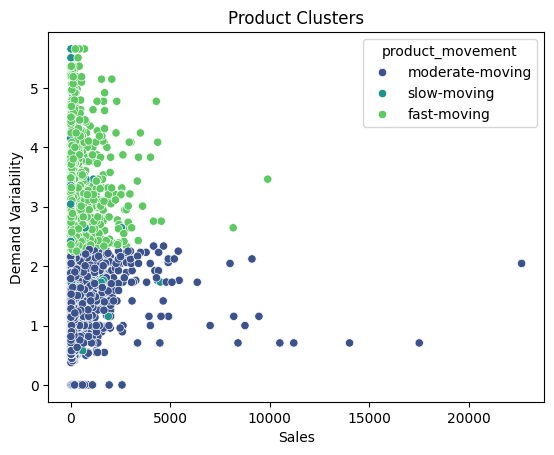

In [132]:
sns.scatterplot(x='sales', y='demand_variability', hue='product_movement', data=df, palette='viridis')
plt.title('Product Clusters')
plt.xlabel('Sales')
plt.ylabel('Demand Variability')
plt.show()

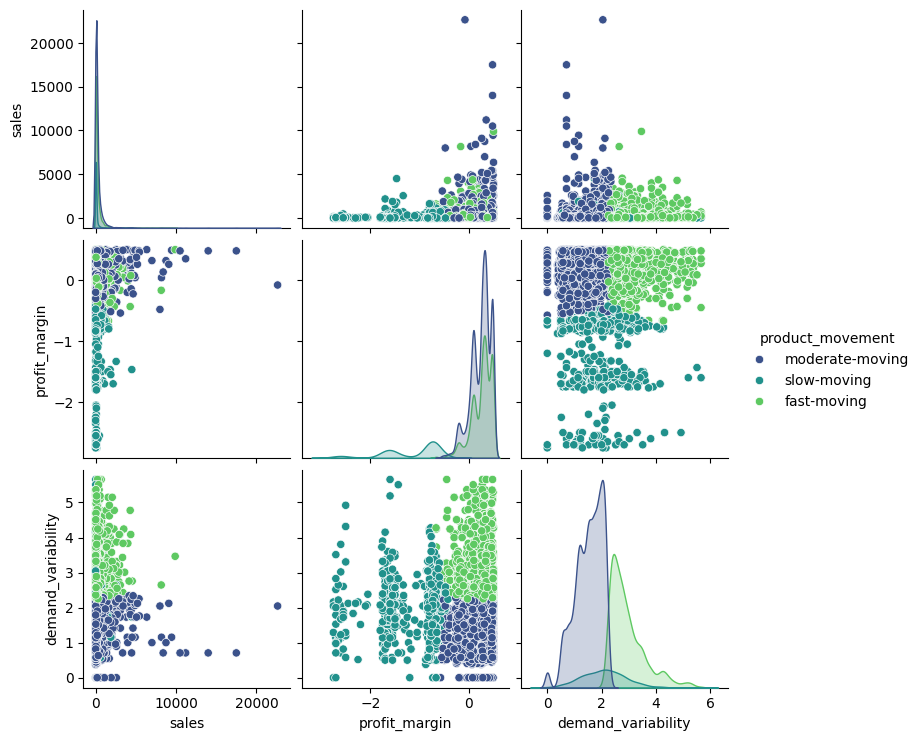

In [133]:
sns.pairplot(df[['sales', 'profit_margin', 'demand_variability', 'product_movement']], hue='product_movement', palette='viridis')
plt.show()

cluster 1 is fast-moving.

cluster 0 is moderate-moving.

cluster 2 is slow-moving.